In [1]:
import boto3
import pandas as pd
from io import StringIO

In [2]:
# Nome do bucket e chave do arquivo CSV no S3
bucket_name = 'victor-mlet-tech-challenge-03'
file_key = 'raw/2024-09-29/healthcare-dataset-stroke-data.csv'

# Cliente S3
s3 = boto3.client('s3')

# Obtém o arquivo CSV/Parquet do S3
response = s3.get_object(Bucket=bucket_name, Key=file_key)
csv_content = response['Body'].read().decode('utf-8')

In [4]:
# Usa o Pandas para ler o CSV/Parquet diretamente da string/memória
df = pd.read_csv(StringIO(csv_content))
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [5]:
# Verificando tamanho do dataset
df.shape

(5110, 12)

In [6]:
# Verificando dados nulos
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [7]:
# Verificando a mediana da coluna 'bmi'
df['bmi'].median()

np.float64(28.1)

In [8]:
# Usando a mediana para preencher os dados nulos
df['bmi'] = df['bmi'].fillna(df['bmi'].median())

In [9]:
# Sem dados nulos após tratamento
df.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [10]:
# Criando uma copia de estado do dataset para iniciar o tratamento das colunas com dados categorias e dimensionamento dos númericos
df2 = df.copy()

In [11]:
# Importe e alocação de bibliotecas do scikit learn que serão usadas
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score

le = LabelEncoder()
ohe = OneHotEncoder()
mms = MinMaxScaler()

lista_label_encoder = ['gender', 'ever_married', 'Residence_type']
lista_one_hot_encoding = ['work_type', 'smoking_status']
lista_min_max_scaler = ['age', 'avg_glucose_level', 'bmi']
drop_columns = ['id']

In [12]:
# Tratamento de colunas categoricas que tinham apenas dois valores em cada, tornando as categorias em 0 e 1
for i in lista_label_encoder:
    df2[i] = le.fit_transform(df2[i])

In [14]:
# Tratamento com One Hot Encoding, transformando colunas categoricas em multiplas colunas binarias.
df_encoded = ohe.fit_transform(df2[lista_one_hot_encoding])
encoded_array = df_encoded.toarray()
encoded_df = pd.DataFrame(encoded_array, columns=ohe.get_feature_names_out())

df3 = pd.concat([df2, encoded_df], axis=1)
df3.drop(['id', 'work_type', 'smoking_status'], axis=1, inplace=True)
df3.head()

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,1,67.0,0,1,1,1,228.69,36.6,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0,61.0,0,0,1,0,202.21,28.1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,1,80.0,0,1,1,0,105.92,32.5,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0,49.0,0,0,1,1,171.23,34.4,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0,79.0,1,0,1,0,174.12,24.0,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [15]:
# Criando mais uma copia de estado do dataset
df4 = df3.copy()

In [16]:
# Aplicação do min max scaler nas colunas de valor númerico num range entre 0 e 1
df4[lista_min_max_scaler] = mms.fit_transform(df4[lista_min_max_scaler])
df4.head()

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,1,0.816895,0,1,1,1,0.801265,0.301260,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0,0.743652,0,0,1,0,0.679023,0.203895,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,1,0.975586,0,1,1,0,0.234512,0.254296,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0,0.597168,0,0,1,1,0.536008,0.276060,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0,0.963379,1,0,1,0,0.549349,0.156930,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


# Treinamento

In [19]:
# Separação do dataset
X = df4.drop(['stroke'], axis=1)
y = df4['stroke'].values

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, random_state=42)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, random_state=42)

In [20]:
# Parametrizando Modelo de Classificação
modelo_rfc = RandomForestClassifier(class_weight='balanced', n_estimators=200, max_depth=8, random_state=42)

In [21]:
# Aplicando cross val score
scores = cross_val_score(modelo_rfc, X_train, y_train, cv=10, scoring='accuracy')

In [22]:
# Acertividade em cada validação cruzada
scores

array([0.89242054, 0.87530562, 0.86797066, 0.88508557, 0.86552567,
       0.87530562, 0.89486553, 0.86797066, 0.86764706, 0.92401961])

In [32]:
print(f"Acurácia média da validação cruzada: {100*scores.mean():.2f}%")
print(f"Desvio padrão da validação cruzada: {100*scores.std():.2f}%")

Acurácia média da validação cruzada: 88.16%
Desvio padrão da validação cruzada: 1.73%


In [29]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
# 1. Treinar o modelo no conjunto de treino completo
modelo_rfc.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=8, n_estimators=200,
                       random_state=42)

In [34]:
# 2. Fazer previsões no conjunto de teste
y_pred = modelo_rfc.predict(X_test)

In [36]:
# 3. Avaliar o desempenho no conjunto de teste
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia no conjunto de teste: {100*accuracy:.2f}%")

Acurácia no conjunto de teste: 86.79%


In [38]:
# Relatório de classificação
print("Relatório de Classificação no Conjunto de Teste:")
print(classification_report(y_test, y_pred))

Relatório de Classificação no Conjunto de Teste:
              precision    recall  f1-score   support

           0       0.96      0.90      0.93       960
           1       0.19      0.35      0.25        62

    accuracy                           0.87      1022
   macro avg       0.57      0.63      0.59      1022
weighted avg       0.91      0.87      0.89      1022



Matriz de Confusão no Conjunto de Teste:


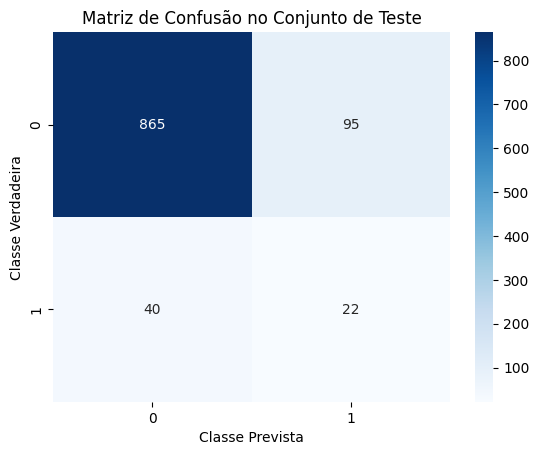

In [39]:
# Matriz de confusão
print("Matriz de Confusão no Conjunto de Teste:")
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusão no Conjunto de Teste")
plt.ylabel('Classe Verdadeira')
plt.xlabel('Classe Prevista')
plt.show()